In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.utils import shuffle
import plotly.graph_objects as go
import csv
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import string
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/warwick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/warwick/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/warwick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [54]:
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout

In [44]:
tesla_stock = pd.read_csv("TSLA.csv", encoding='latin1')
n_data = tesla_stock.shape[0]
feature_list = tesla_stock.columns
print("the number of stock data is:", n_data)
print("features are:", feature_list)
print("the number of features are:", len(feature_list))

times = tesla_stock['Date'][:].tolist()
times = [s.replace("-", "") for s in times]
tesla_stock.loc[:,("times")] = times
print(tesla_stock["times"].head(5))

#we only consider stock between 2012/11/15 and 2017/09/29, in accord with Elon Musk's tweet
tesla = tesla_stock[(tesla_stock.times >= "20121115") & (tesla_stock.times <= "20170929")]
print(tesla['times'].head(1))
print(tesla['times'].tail(1))
print("the number of trading days between 2012/11/15 and 2017/09/29 is:",tesla.shape[0])

"""
times = [s[4:8]+s[0:4] for s in times]
tesla_stock.loc[:,("time_string")] = times
print(tesla_stock['time_string'][0:5])
"""


the number of stock data is: 2416
features are: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
the number of features are: 7
0    20100629
1    20100630
2    20100701
3    20100702
4    20100706
Name: times, dtype: object
601    20121115
Name: times, dtype: object
1827    20170929
Name: times, dtype: object
the number of trading days between 2012/11/15 and 2017/09/29 is: 1227


'\ntimes = [s[4:8]+s[0:4] for s in times]\ntesla_stock.loc[:,("time_string")] = times\nprint(tesla_stock[\'time_string\'][0:5])\n'

In [4]:
tesla.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1226.000000,1226.000000,1226.000000,1226.000000,1226.000000,1.226000e+03
mean,206.202480,209.603328,202.575114,206.175155,206.175155,5.996518e+06
std,77.449504,78.175534,76.447409,77.339418,77.339418,4.356446e+06
min,31.150000,32.000000,30.590000,31.840000,31.840000,3.758000e+05
25%,180.174999,184.785000,176.049999,181.012497,181.012497,3.344275e+06
50%,215.750000,219.189995,211.310005,216.254997,216.254997,4.904850e+06
75%,248.237499,251.744996,245.315006,248.387497,248.387497,7.363250e+06
max,386.690002,389.609985,379.350006,385.000000,385.000000,3.716390e+07


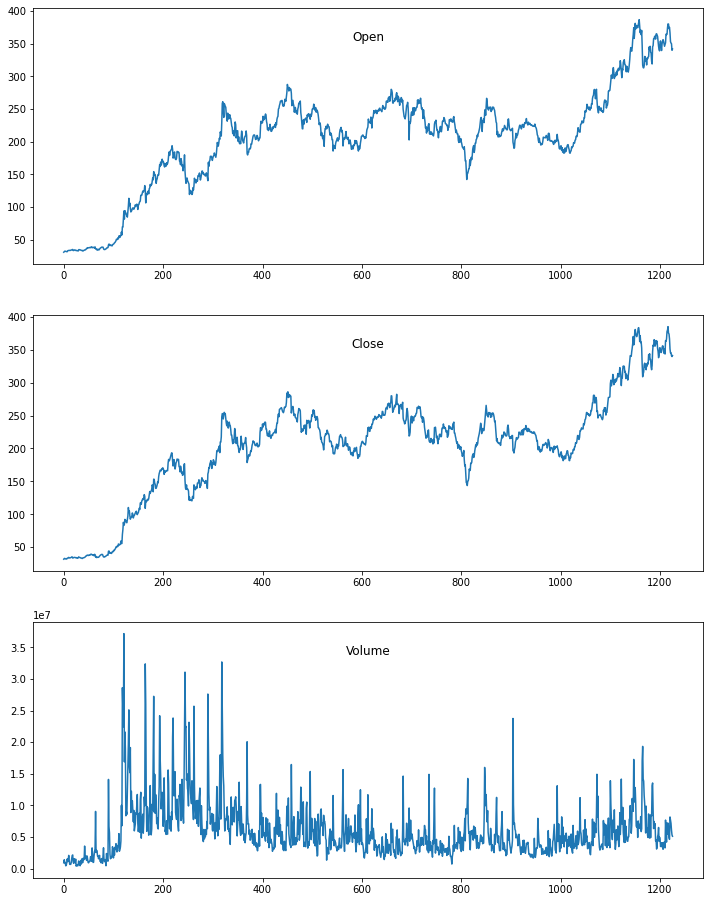

In [5]:
values = tesla.values
groups = [1,4,6]
plt.figure(figsize = (12,16))
i = 1
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(tesla.columns[group], y=0.85, loc='center')
    i += 1
plt.show()

In [84]:
#we only consider the closing price of stock each day. Consider two consecutive day i and j
#we consider the price is increasing if closing price(j) > closing price(i) and vice versa
#
# Baseline model: simple LSTM with only consideration of closing price
#

close_price_dataframe = tesla.filter(['Close'])
close_price = close_price_dataframe.values
scaler = MinMaxScaler(feature_range=(0,1))

#create a scaled closing price
scaled_close_price = scaler.fit_transform(close_price)


#split data so that the first 87% data as training data and the rest 30% as validation dataset
training_data_len = int(np.ceil(len(scaled_close_price) * 0.7 ))

train_data = scaled_close_price
x_train = []
y_train = []


#price of stock based on previous 1 month 
threshold = 30


#in LSTM, the value of y depends on previous 30 days
for i in range(threshold, len(train_data)):
    x_train.append(train_data[i-threshold:i, 0])
    y_train.append(train_data[i, 0])
    if i<= (threshold+1):
        print(x_train)
        print(y_train)
        
# Convert data to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))




[array([0.        , 0.00287989, 0.00592918, 0.00615506, 0.00465865,
       0.00369869, 0.00409396, 0.00375516, 0.00680445, 0.00810322,
       0.00847027, 0.01072901, 0.00869615, 0.00815969, 0.00869615,
       0.00945846, 0.01058784, 0.01259246, 0.01253599, 0.00787735,
       0.00844204, 0.01010786, 0.01064431, 0.01070078, 0.01019256,
       0.00897849, 0.00976904, 0.00782088, 0.00810322, 0.00677622])]
[0.00861143768705179]
[array([0.        , 0.00287989, 0.00592918, 0.00615506, 0.00465865,
       0.00369869, 0.00409396, 0.00375516, 0.00680445, 0.00810322,
       0.00847027, 0.01072901, 0.00869615, 0.00815969, 0.00869615,
       0.00945846, 0.01058784, 0.01259246, 0.01253599, 0.00787735,
       0.00844204, 0.01010786, 0.01064431, 0.01070078, 0.01019256,
       0.00897849, 0.00976904, 0.00782088, 0.00810322, 0.00677622]), array([0.00287989, 0.00592918, 0.00615506, 0.00465865, 0.00369869,
       0.00409396, 0.00375516, 0.00680445, 0.00810322, 0.00847027,
       0.01072901, 0.00869615, 0.0

In [85]:
#Build the LSTM model
model = Sequential()
#one hidden layer contains 50 neurons
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model with 1 epoch
model.fit(x_train, y_train, batch_size=1, epochs=1)

1197/1197 [==============================] - 9s 8ms/step - loss: 0.0028


In [86]:
test_data = scaled_close_price[training_data_len - threshold: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = close_price[training_data_len:, :]
for i in range(threshold, len(test_data)):
    x_test.append(test_data[i-threshold:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


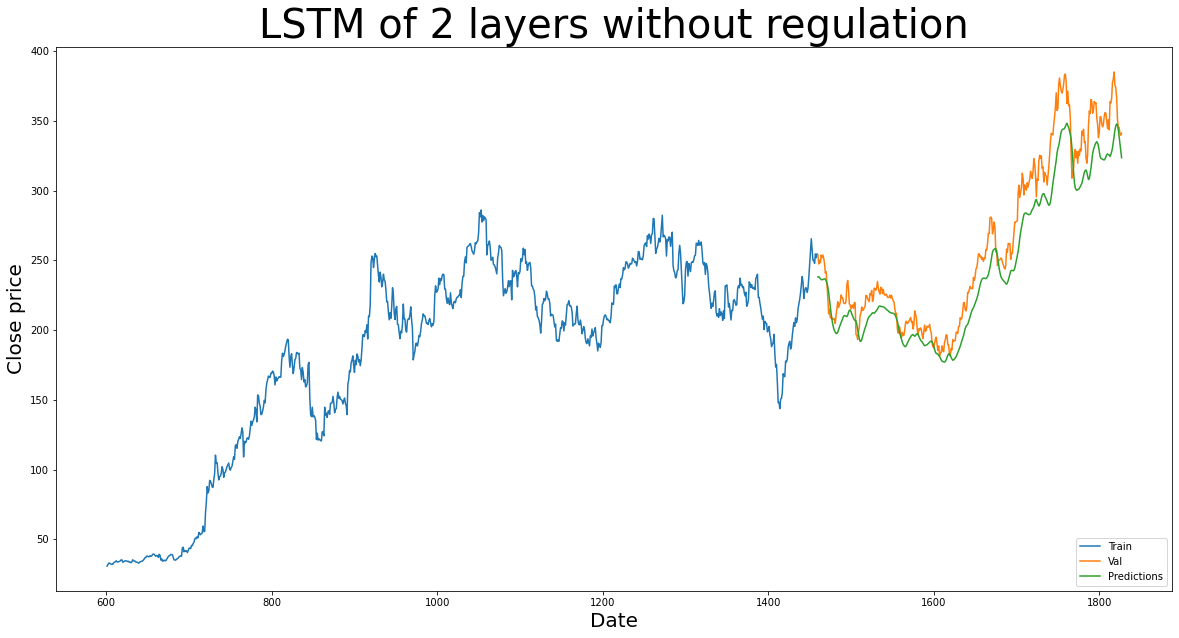

the root mean squared error of LSTM: 20.517672589138257


In [87]:
# Plot the data
train = close_price_dataframe[:training_data_len]
valid = close_price_dataframe[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(20,10))
plt.title('LSTM of 2 layers without regulation',fontsize = 40)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close price', fontsize=20)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("the root mean squared error of LSTM:", rmse)

In [88]:
print(valid)

           Close  Predictions
1460  253.880005   238.052719
1461  247.369995   238.194305
1462  249.970001   237.547134
1463  248.289993   236.912735
1464  253.750000   236.147598
...          ...          ...
1823  344.989990   343.624237
1824  345.250000   338.474670
1825  340.970001   333.214172
1826  339.600006   328.048553
1827  341.100006   323.521118

[368 rows x 2 columns]


In [89]:
#whether prediction correctly suggest stock price is increasing or decreasing
def get_accuracy(valid_set):
    temp = close_price[training_data_len-1]
    close = valid_set['Close'].tolist()
    prediction = valid_set['Predictions'].tolist()
    count = 0
    if (temp>close[0] == temp>prediction[0]):
        count+=1
    for i in range(len(close)-1):
        if (close[i]>close[i+1] and prediction[i]>prediction[i+1]) or (close[i]<close[i+1] and prediction[i]<prediction[i+1]):
            count+=1
    return count/len(close)

print(get_accuracy(valid))

0.5


In [90]:

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

1197/1197 [==============================] - 18s 15ms/step - loss: 0.0089


In [91]:
test_data = scaled_close_price[training_data_len - threshold: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = close_price[training_data_len:, :]
for i in range(threshold, len(test_data)):
    x_test.append(test_data[i-threshold:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


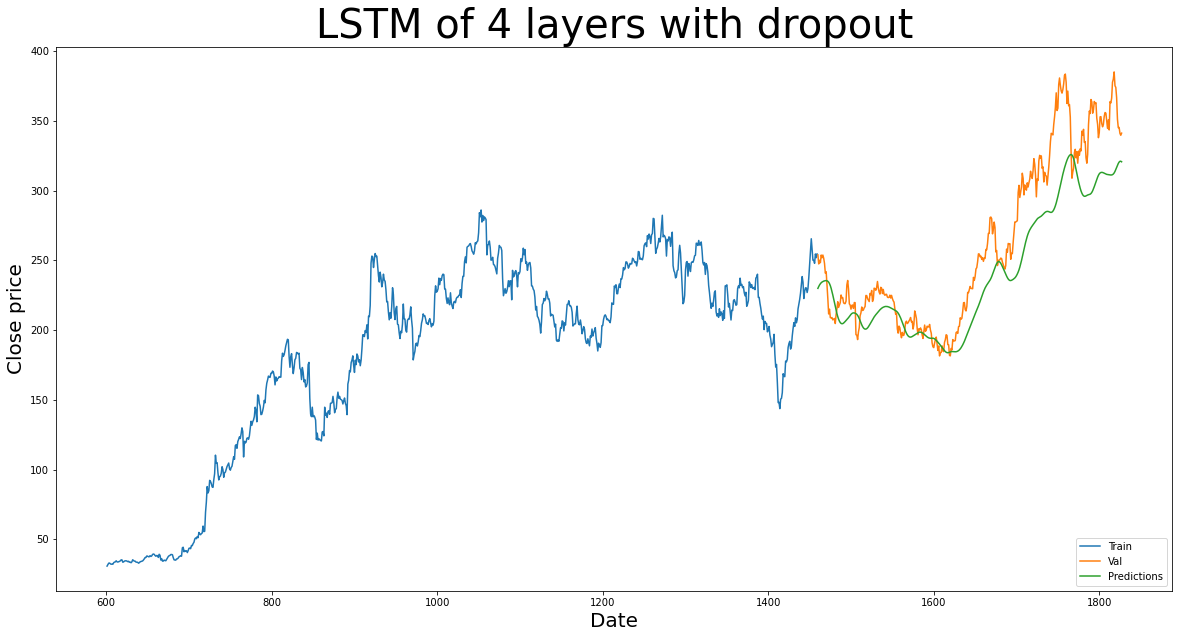

the root mean squared error of LSTM: 30.15473051895895


In [92]:
# Plot the data
train = close_price_dataframe[:training_data_len]
valid = close_price_dataframe[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(20,10))
plt.title('LSTM of 4 layers with dropout',fontsize = 40)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close price', fontsize=20)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("the root mean squared error of LSTM:", rmse)